<a href="https://colab.research.google.com/github/kevin200010/git-test/blob/master/Facial_emotion__detection_using_MobileNet_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
!pip install scikit-plot
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [4]:
%cd  /content/data_for
!unzip -q "/content/drive/MyDrive/final_dataset.zip"

/content/data_for


In [5]:
INPUT_PATH = "/content/data_for/"

total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")


Neutral has 4295 number of images
Surprise has 3171 number of images
Angry has 2832 number of images
Happy has 6834 number of images
Sad has 4806 number of images

total images are 21938


In [6]:
TOP_EMOTIONS = ["Happy", "Neutral", "Angry" , "Sad" , "Surprise"]

total_images

21938

In [7]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Neutral images to numpy arrays
loaded all Surprise images to numpy arrays
loaded all Angry images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Sad images to numpy arrays


((21938, 48, 48, 3), array([0., 0., 0., ..., 4., 4., 4.]))

In [8]:
label_to_text


{0: 'Neutral', 1: 'Surprise', 2: 'Angry', 3: 'Happy', 4: 'Sad'}

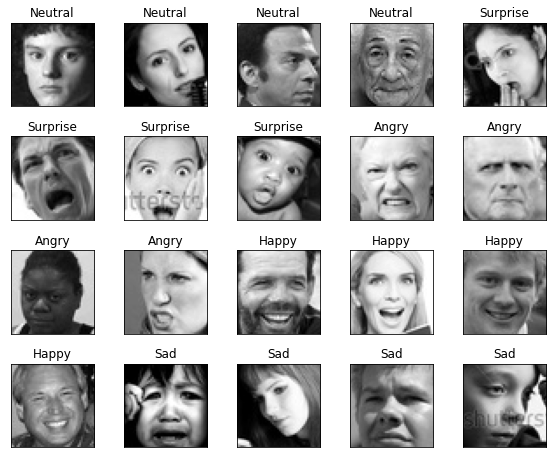

In [10]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(5,5,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [11]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(21938, 5)

# **Splitting the data into training and validation set.**

In [12]:
img_arr = img_arr / 255.



In [13]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19744, 48, 48, 3), (2194, 48, 48, 3), (19744, 5), (2194, 5))

In [14]:
del img_arr
del img_label

In [15]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [16]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

17227776/17225924 [==============================] - 0s 0us/step


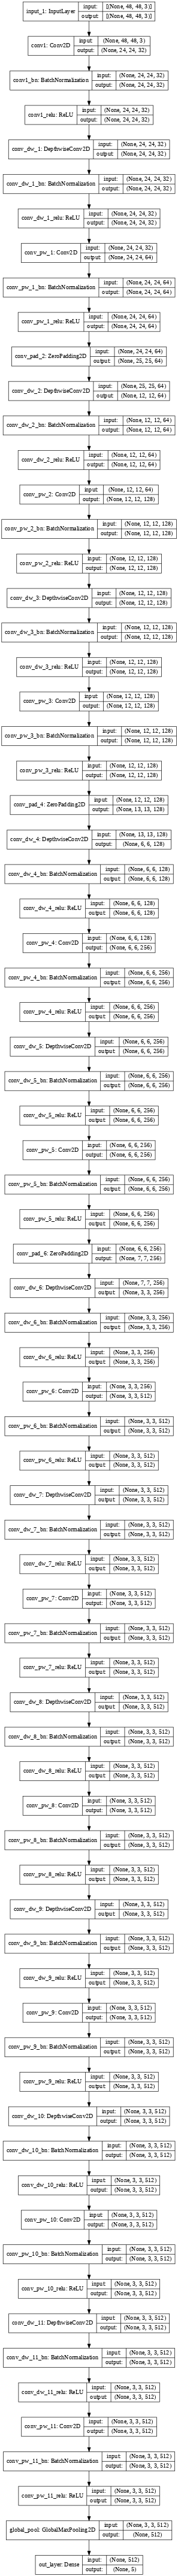

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [ ]:
for (i,layer) in enumerate(model.layers):
    print(str(i),layer.__class__.__name__,layer.trainable)


In [19]:
for layer in model.layers[:15]:
    layer.trainable = False

for (i,layer) in enumerate(model.layers):
    print(str(i),layer.__class__.__name__,layer.trainable)

  

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 ReLU False
10 ZeroPadding2D False
11 DepthwiseConv2D False
12 BatchNormalization False
13 ReLU False
14 Conv2D False
15 BatchNormalization True
16 ReLU True
17 DepthwiseConv2D True
18 BatchNormalization True
19 ReLU True
20 Conv2D True
21 BatchNormalization True
22 ReLU True
23 ZeroPadding2D True
24 DepthwiseConv2D True
25 BatchNormalization True
26 ReLU True
27 Conv2D True
28 BatchNormalization True
29 ReLU True
30 DepthwiseConv2D True
31 BatchNormalization True
32 ReLU True
33 Conv2D True
34 BatchNormalization True
35 ReLU True
36 ZeroPadding2D True
37 DepthwiseConv2D True
38 BatchNormalization True
39 ReLU True
40 Conv2D True
41 BatchNormalization True
42 ReLU True
43 DepthwiseConv2D True
44 BatchNormalization True
45 ReLU True
46 Conv2D True
47 BatchNormalization True
48 ReLU True
49 DepthwiseConv2D Tru

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [21]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]


In [22]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
789/789 [==============================] - 213s 266ms/step - loss: 1.8540 - accuracy: 0.3925 - val_loss: 1.1152 - val_accuracy: 0.5542
Epoch 2/40
789/789 [==============================] - 222s 281ms/step - loss: 1.1348 - accuracy: 0.5545 - val_loss: 1.1561 - val_accuracy: 0.5820
Epoch 3/40
789/789 [==============================] - 230s 290ms/step - loss: 1.0430 - accuracy: 0.5957 - val_loss: 1.2290 - val_accuracy: 0.5137
Epoch 4/40
789/789 [==============================] - 225s 285ms/step - loss: 1.0003 - accuracy: 0.6082 - val_loss: 1.0414 - val_accuracy: 0.6130
Epoch 5/40
789/789 [==============================] - 221s 279ms/step - loss: 0.9626 - accuracy: 0.6295 - val_loss: 0.9280 - val_accuracy: 0.6345
Epoch 6/40
789/789 [==============================] - 224s 283ms/step - loss: 0.9375 - accuracy: 0.6366 - val_loss: 0.9891 - val_accuracy: 0.6322
Epoch 7/40
789/789 [==============================] - 227s 287ms/step - loss: 0.9257 - accuracy: 0.6468 - val_loss: 0.8806 -

In [23]:
model_yaml = model.to_yaml()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

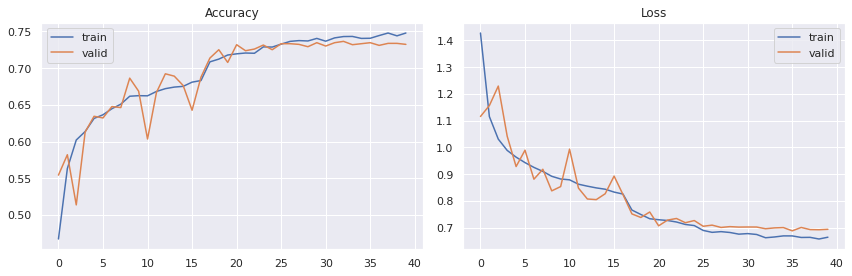

In [24]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [25]:
label_to_text
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Angry': 2, 'Happy': 3, 'Neutral': 0, 'Sad': 4, 'Surprise': 1}

test accuracy: 73.24521 %


              precision    recall  f1-score   support

           0       0.58      0.72      0.65       430
           1       0.82      0.84      0.83       317
           2       0.63      0.54      0.58       283
           3       0.89      0.84      0.87       683
           4       0.67      0.62      0.65       481

    accuracy                           0.73      2194
   macro avg       0.72      0.71      0.71      2194
weighted avg       0.74      0.73      0.73      2194



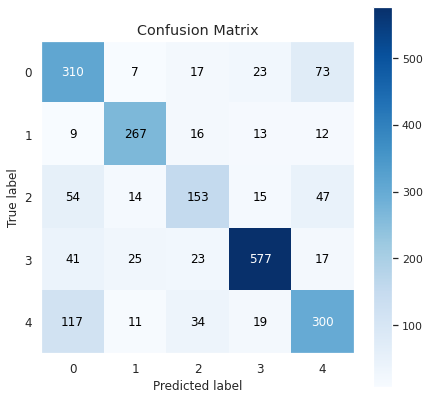

In [26]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 5)} %\n\n")

print(classification_report(ytest_, yhat_test))